In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_parquet("data/green_tripdata_2021-01.parquet")

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

/home/jaka/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jaka/miniconda3/envs/tf/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


9.775464298045627

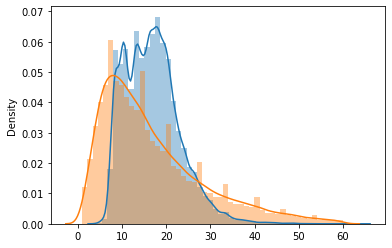

In [3]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

sns.distplot(y_pred, label="pred", bins=50)
sns.distplot(y_train, label="actual", bins=50)

mean_squared_error(y_pred, y_train, squared=False)

In [4]:
X_train[:10].todense()

matrix([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.01],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 2.53],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.12],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 6.69],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 2.34],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 5.48]])

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = read_dataframe("data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("data/green_tripdata_2021-02.parquet")

In [7]:
len(df_train), len(df_val)

(73908, 61921)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
categorical = ['PU_DO']  # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [10]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

display(mean_squared_error(y_pred_train, y_train, squared=False))
display(mean_squared_error(y_pred_val, y_val, squared=False))

4.6408595169067155

7.479352262681921

In [12]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [13]:
lr_lasso = Lasso(0.0001)
lr_lasso.fit(X_train, y_train)

y_pred_val = lr_lasso.predict(X_val)

display(mean_squared_error(y_pred_val, y_val, squared=False))

7.616617761096093